In [1]:
import numpy as np
train=np.load('./out/tiny_test.npy')
train_mask=np.load('./out/tiny_test_mask.npy')

train = train.astype('float32')
mini = np.min(train)  # mean for data centering
maxi = np.max(train)  # std for data normalization
train -= mini
train /= (maxi -mini)

train_mask = train_mask.astype('float32')
mask_max=np.max(train_mask)
train_mask/=mask_max
# scale masks to [0, 1]
print(train.shape, train_mask.shape)
print(np.min(train), np.max(train), np.min(train_mask),np.max(train_mask))


(100, 96, 96, 1) (100, 96, 96, 1)
0.0 1.0 0.0 1.0


In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, Activation
from tensorflow.keras.layers import BatchNormalization , Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy
import tensorflow as tf


smooth = 1.

smooth = 1.


def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

### customized unet loss function in order to ensure sucess and fast training 
def combined_dice_binary_loss(y_true,y_pred):
    def dice_loss(y_true,y_pred):
        numerator= 2 * tf.reduce_sum( y_true * y_pred, axis=(1,2,3))
        denominator = tf.reduce_sum(y_true +y_pred, axis=(1,2,3))
        return tf.reshape(1-numerator/denominator, (-1,1,1))
    return binary_crossentropy(y_true,y_pred)+dice_loss(y_true,y_pred)
def get_unet():
    inputs = Input((96, 96, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])

    return model
model=get_unet()
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 96, 96, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 96, 96, 32)   9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 48, 48, 32)   0           conv2d_1[0

In [3]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os
EPOCHS = 1
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=99)
checkpoint_path = "ngc_test"

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    monitor='val_loss',
    save_best_only=True)

model_history = model.fit(train, train_mask, batch_size=12, epochs=EPOCHS, verbose=1, shuffle=True,validation_data=(train,train_mask),
          callbacks=[cp_callback,early_stopping_callback])

Train on 100 samples, validate on 100 samples
100/100 [==============================] - 3s 35ms/sample - loss: -0.0550 - dice_coef: 0.0556 - val_loss: -0.0550 - val_dice_coef: 0.0550


In [4]:
# Save the weights
#model.save_weights('./ngc_checkpoint_weight')

# Create a new model instance
m = get_unet()

# Restore the weights
m.load_weights('./ngc_checkpoint_weight')


In [9]:
print(m.inputs,m.outputs)

for layer in m.layers:
    print(layer.name)


[<tf.Tensor 'input_2:0' shape=(?, 96, 96, 1) dtype=float32>] [<tf.Tensor 'conv2d_37/Sigmoid:0' shape=(?, 96, 96, 1) dtype=float32>]
input_2
conv2d_19
conv2d_20
max_pooling2d_4
conv2d_21
conv2d_22
max_pooling2d_5
conv2d_23
conv2d_24
max_pooling2d_6
conv2d_25
conv2d_26
max_pooling2d_7
conv2d_27
conv2d_28
conv2d_transpose_4
concatenate_4
conv2d_29
conv2d_30
conv2d_transpose_5
concatenate_5
conv2d_31
conv2d_32
conv2d_transpose_6
concatenate_6
conv2d_33
conv2d_34
conv2d_transpose_7
concatenate_7
conv2d_35
conv2d_36
conv2d_37


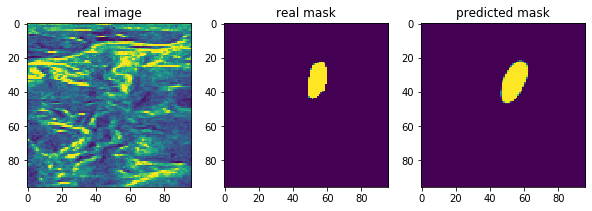

In [6]:
import matplotlib.pyplot as plt
import random
rn=random.randint(0,len(train)-1)
%matplotlib inline
out= m.predict(train[rn].reshape(1,96,96,1))
fig = plt.figure(figsize=(10,10))
fig.add_subplot(1,3,1)
plt.imshow(np.squeeze(train[rn]*96))
plt.title('real image')

fig.add_subplot(1,3,2)
plt.imshow(np.squeeze(train_mask[rn]))
plt.title('real mask')


fig.add_subplot(1,3,3)
plt.imshow(np.squeeze(out))
plt.title('predicted mask')

plt.show()


In [11]:
!pip install tf-explain

# visualize with tensorboard using tf-explain

In [6]:
from tensorboard import notebook
notebook.list() # View open TensorBoard instances


No known TensorBoard instances running.


In [ ]:
!tensorboard --logdir=logs --host localhost --port 8088

In [ ]:
%%html
<table cellspacing='1'>
<td>  
    <td> <img src="model.JPG" alt="image" style="width: 1500px;"/> </td>
</table>

In [7]:
%%html
<table cellspacing='1'>
<td>  
    <td> <img src="tensorboard_visualize.JPG" alt="image" style="width: 1500px;"/> </td>
</table>

In [8]:
# Control TensorBoard display. If no port is provided, 
# the most recently launched TensorBoard is used
#notebook.display(port=6006, height=800)

In [25]:
from tf_explain.callbacks.grad_cam import GradCAMCallback


callbacks = [
    GradCAMCallback(
        validation_data=(train, train_mask),
        layer_name="conv2d_18",
        class_index=1,
        output_dir='./logs',
    )
]

m.fit(train, train_mask, batch_size=2, epochs=2, callbacks=callbacks)

Train on 100 samples
Epoch 1/2
100/100 [==============================] - 15s 149ms/sample - loss: -0.6513 - dice_coef: 0.6513
Epoch 2/2
100/100 [==============================] - 15s 151ms/sample - loss: -0.6367 - dice_coef: 0.6367


In [10]:
from tf_explain.callbacks.activations_visualization import ActivationsVisualizationCallback

callbacks = [
    ActivationsVisualizationCallback(
        validation_data=(train, train_mask),
        layers_name=["conv2d_16"],
        output_dir='./logs',
    ),
]

m.fit(train, train_mask, batch_size=2, epochs=2, callbacks=callbacks)

Train on 100 samples
Epoch 1/2
100/100 [==============================] - 18s 182ms/sample - loss: -0.6205 - dice_coef: 0.6205
Epoch 2/2
100/100 [==============================] - 18s 181ms/sample - loss: -0.6472 - dice_coef: 0.6472


In [14]:
from __future__ import absolute_import, division, print_function, unicode_literals

from IPython.display import clear_output
import matplotlib.pyplot as plt
from tf_explain.callbacks.activations_visualization import ActivationsVisualizationCallback

from tf_explain.callbacks.gradients import VanillaGradientsCallback
from tf_explain.callbacks.occlusion_sensitivity import OcclusionSensitivityCallback
from tf_explain.callbacks.grad_cam import GradCAMCallback
from tf_explain.callbacks.smoothgrad import SmoothGradCallback
from tf_explain.callbacks.integrated_gradients import IntegratedGradientsCallback